# 1) Installations

In [1]:
!pip install torch torchdata
# !pip install transformers==4.35
!pip install transformers datasets
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -U accelerate
!pip install evaluate rouge_score
!pip install -qqq trl==0.7.1
!pip install loralib

!pip install loralib peft
# !pip install accelerate==0.20.3
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=bc872b4b3ce21c53f61383db78d37128b23b51ca72c58e9d1e062ac3c4a644a9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.6 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from datasets import load_dataset, DatasetDict, load_metric
import accelerate

import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


print("torch ver:", torch. __version__ )
# print("transformers ver:", transformers.__version__)
print("accelerate ver:",accelerate.__version__)

torch ver: 2.1.0+cu121
accelerate ver: 0.25.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Running on:', device)

Running on: cuda


In [5]:
seperator_print_short = '-'.join('' for x in range(100))
seperator_print_long = '-'.join('' for x in range(140))

def print_input_outputs(i, index, input, label, model_output):
    print(seperator_print_long)

    print(f"Sample {i+1}: Index = {index}")
    print(seperator_print_short)

    print(f"INPUT:")
    print(input)
    print(seperator_print_short)

    print("DATASET ORIGINAL LABEL:")
    print(label)
    print(seperator_print_short)

    if model_output != "":
        print("OUTPUT OF THE MODEL")
        print(model_output)
        print(seperator_print_short)

    print(seperator_print_long)



# 2) Data Preprocessing & Model Setup

In [7]:
# dataset_src = './arxiv_title_abs_CS_2000.csv'
dataset_src = "/content/drive/MyDrive/datasets/arxiv_title_abs_CS_v2.csv"
dataset_origin = load_dataset('csv',
                       data_files=dataset_src
                       )
dataset_origin

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 299131
    })
})

In [9]:
dset_train_test = (load_dataset('csv',
                        data_files=dataset_src,
                        split='train'
                        )
          .train_test_split(train_size=0.7)
          )

dset_train_test

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 209391
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 89740
    })
})

In [10]:
dset_test_val = dset_train_test["test"].train_test_split(train_size=0.75)
# train --> validation
# test --> test
dset_test_val

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 67305
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 22435
    })
})

In [11]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 209391
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 67305
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 22435
    })
})

In [12]:
# limit number of samples

dataset['train'] = dataset['train'].shuffle().select([i for i in range(6000)])
dataset['validation'] = dataset['validation'].shuffle().select([i for i in range(1000)])
dataset['test'] = dataset['test'].shuffle().select([i for i in range(250)])
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 250
    })
})

In [13]:
INPUT_COL_NAME = "abstract"
OUTPUT_COL_NAME = "title"

In [14]:
samples_to_check = [10, 15]

for i, index in enumerate(samples_to_check):
    print_input_outputs(i,
                        index,
                        input=dataset['train'][index][INPUT_COL_NAME],
                        label=dataset['train'][index][OUTPUT_COL_NAME],
                        model_output = "")

-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:
  COVID-19 pandemic continues to spread rapidly over the world and causes a tremendous crisis in global human health and the economy. Its early detection and diagnosis are crucial for controlling the further spread. Many deep learning-based methods have been proposed to assist clinicians in automatic COVID-19 diagnosis based on computed tomography imaging. However, challenges still remain, including low data diversity in existing datasets, and unsatisfied detection resulting from insufficient accuracy and sensitivity of deep learning models. To enhance the data diversity, we design augmentation techniques of incremental levels and apply them to the largest open-access benchmark dataset, COVIDx CT-2A. Meanwhile, similarity 

BNB Config

In [ ]:
# from transformers import BitsAndBytesConfig

# # nested quantization (4bit using NF4 quantization)
# # bnb_4bit_use_double_quant: second quatnization after the
# #                            first one to save add 0.4 bits
# BNB_NF4_CONFIG = BitsAndBytesConfig(
#     load_in_4bit=True,                    # enable 4-bit quantization
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

Model

In [15]:
model_id='facebook/bart-base'
# model_id='google/flan-t5-base'
# model_id='google/flan-t5-small'
# model_id='lucadiliello/bart-small'

model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                              # quantization_config = BNB_NF4_CONFIG,
                                              # device_map = "auto"
                                              )

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          use_fast=True,
                                          )

# # config tokenizer: assign the eos_token to the pad_token
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
for i, index in enumerate(samples_to_check):
    abstract = dataset['train'][index][INPUT_COL_NAME]
    title = dataset['train'][index][OUTPUT_COL_NAME]

    inputs = tokenizer(abstract, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=25,
        )[0],
        skip_special_tokens=True
    )

    print_input_outputs(i,
                        index,
                        input=abstract,
                        label=title,
                        model_output=output)

-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:
  COVID-19 pandemic continues to spread rapidly over the world and causes a tremendous crisis in global human health and the economy. Its early detection and diagnosis are crucial for controlling the further spread. Many deep learning-based methods have been proposed to assist clinicians in automatic COVID-19 diagnosis based on computed tomography imaging. However, challenges still remain, including low data diversity in existing datasets, and unsatisfied detection resulting from insufficient accuracy and sensitivity of deep learning models. To enhance the data diversity, we design augmentation techniques of incremental levels and apply them to the largest open-access benchmark dataset, COVIDx CT-2A. Meanwhile, similarity 

## 2.1) Prompt Engineering

Zero-Shot Inference

In [17]:
for i, index in enumerate(samples_to_check):
    abstract = dataset['train'][index][INPUT_COL_NAME]
    title = dataset['train'][index][OUTPUT_COL_NAME]

    prompt=f'''
    Generate a title related to the given abstract:
    {abstract}

    Generated Title:
    '''

    inputs=tokenizer(prompt,return_tensors='pt')
    output=tokenizer.decode(
        model.generate(
            inputs['input_ids'],
            max_new_tokens=512,
        )[0],
        skip_special_tokens=True
    )

    print_input_outputs(i,
                        index,
                        input=prompt,
                        label=title,
                        model_output=output)


-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:

    Generate a title related to the given abstract:
      COVID-19 pandemic continues to spread rapidly over the world and causes a tremendous crisis in global human health and the economy. Its early detection and diagnosis are crucial for controlling the further spread. Many deep learning-based methods have been proposed to assist clinicians in automatic COVID-19 diagnosis based on computed tomography imaging. However, challenges still remain, including low data diversity in existing datasets, and unsatisfied detection resulting from insufficient accuracy and sensitivity of deep learning models. To enhance the data diversity, we design augmentation techniques of incremental levels and apply them to the largest open-acces

One Shot Inference

In [18]:
def create_one_shot_prompt(base_given_dialogues, test_dialgoue_index):
    prompt='There is an example dialogue with its summary:'

    # add base samples in prompt firstly
    for index in base_given_dialogues:
      abstract = dataset['test'][index][INPUT_COL_NAME]
      title = dataset['test'][index][OUTPUT_COL_NAME]

      prompt+=f"""
              Given abstract:
              {abstract}

              The title of the abstract given above:
              {title}
              """

    # add test abstract
    test_abstract = dataset['test'][test_dialgoue_index][INPUT_COL_NAME]
    prompt+=f"""
              Generate a title related to the given abstract:
              {test_abstract}

              Generated title:
              """
    return prompt


In [19]:
base_given_dialogues=[10]
test_dialgoue_index=20

# input (with one shot prompt)
one_shot_prompt = create_one_shot_prompt(base_given_dialogues, test_dialgoue_index)
print(one_shot_prompt)
print("\n\n\n")

# label
title_new = dataset['test'][test_dialgoue_index][OUTPUT_COL_NAME]

# model output
inputs=tokenizer(one_shot_prompt,return_tensors='pt')
output=tokenizer.decode(
    model.generate(
        inputs['input_ids'],
        max_new_tokens=512,
    )[0],
    skip_special_tokens=True
)

print_input_outputs(i,
                    index,
                    input=one_shot_prompt,
                    label=title_new,
                    model_output=output)


There is an example dialogue with its summary:
              Given abstract:
                Deceptive and anti-deceptive technologies have been developed for various specific applications. But there is a significant need for a general, holistic, and quantitative framework of deception. Game theory provides an ideal set of tools to develop such a framework of deception. In particular, game theory captures the strategic and self-interested nature of attackers and defenders in cybersecurity. Additionally, control theory can be used to quantify the physical impact of attack and defense strategies. In this tutorial, we present an overview of game-theoretic models and design mechanisms for deception and counter-deception. The tutorial aims to provide a taxonomy of deception and counter-deception and understand how they can be conceptualized, quantified, and designed or mitigated. This tutorial gives an overview of diverse methodologies from game theory that includes games of incomplete info

In [ ]:
# summary = dataset['test'][test_dialgoue_index]['summary']

# inputs=tokenizer(one_shot_prompt,return_tensors='pt')
# output=tokenizer.decode(
#     model.generate(
#         inputs['input_ids'],
#         max_new_tokens=200,
#     )[0],
#     skip_special_tokens=True
# )
# print(dash_line)
# print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
# print(dash_line)
# print(f'MODEL GENERATION - ONE SHOT:\n{output}')

# 3) Model

## 3.1) Fine Tuning with PEFT

In [20]:
def trainable_model_params(model):
  trainable_params=0
  all_params=0
  for _,param in model.named_parameters():
    all_params+=param.numel()
    if param.requires_grad:
      trainable_params+=param.numel()
  return f"trainable params: {trainable_params}\nall params: {all_params}\npercentage of trainable params: {100*trainable_params/all_params}"
print(trainable_model_params(model))

trainable params: 139420416
all params: 139420416
percentage of trainable params: 100.0


LoRA

In [ ]:
# # # use significantly less GPU memory
# # # activation checkpointing: freeze huge memory with small decrease in training speed
# # model.gradient_checkpointing_enable()

In [ ]:
# # from peft import prepare_model_for_kbit_training

# # # add training adapters
# # model = prepare_model_for_kbit_training(model, use_gradient_checkpointing = True)

In [24]:
LORA_R = 8
LORA_ALPHA = 64         # scaling coefficient for LoRA
LORA_DROPOUT = 0.01

lora_config=LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    target_modules = ["q_proj","v_proj"],
    # target_modules=["q", "v"],
    lora_dropout = LORA_DROPOUT,
    bias = "lora_only",                     # check with "none"
    task_type = TaskType.SEQ_2_SEQ_LM
)

# model.enable_input_require_grads()

peft_model=get_peft_model(model,lora_config)

print(trainable_model_params(peft_model))

trainable params: 552960
all params: 139973376
percentage of trainable params: 0.3950465551391716


Tokenizer

In [25]:
def tokenize_function(example):
    START_prompt = 'Generate a relevant title related to the given abstracte:'
    END_prompt = '\n\nGenerated Title: '

    prompt = [START_prompt + abstract + END_prompt for abstract in example[INPUT_COL_NAME]]
    example['input_ids'] = tokenizer(prompt,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors="pt").input_ids

    example['labels'] = tokenizer(example["title"],
                                  padding="max_length",
                                  truncation=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['title', 'abstract','Unnamed: 0', 'categories'])

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [26]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 250
    })
})


PEFT

In [27]:
output_model_name = "bart"
output_config_option = "peftqlora"
output_task = "title-generation"
output_ver = "v1-3"

OUTPUT_DIR = f'./{output_model_name}-{output_config_option}-{output_task}-{output_ver}'

In [29]:
# MAIN PARAMS
NUM_EPOCHS = 6
L_RATE = 2e-4
TRAIN_OPTIMIZER = "paged_adamw_32bit"      # "paged_adamw_32bit"

# OTHER PARAMS
EVAL_STEPS = 0.2
LR_SCHED_TYPE = "cosine"

peft_training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,

    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2, # accumulating gradients over several batches

    learning_rate = L_RATE,
    optim = TRAIN_OPTIMIZER,
    lr_scheduler_type = LR_SCHED_TYPE,
    # max_grad_norm = 0.4,             # for gradient clipping
    # warmup_ratio = 0.02,             # ratio of total training steps used in [0, LR]

    logging_steps = 4,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",      # set "steps" to see each val step
    # eval_steps = 4,
    # logging_strategy= "epoch",

    logging_dir = f"{OUTPUT_DIR}/logs",
    # save_strategy = "epoch",

    # load_best_model_at_end = True,
    # save_total_limit=2,
    metric_for_best_model = 'eval_loss',
    save_strategy = "epoch"

)

model.config.use_cache = False

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],
    # compute_metrics=compute_metrics
    # neftune_noise_alpha=5,             # use NEFTune
    # data_collator=data_collator,
    # max_seq_length=1024,
)

In [30]:
T_START_TRAIN = time.time()
peft_trainer.train()
T_END_TRAIN = time.time()

Epoch,Training Loss,Validation Loss
1,5.392100,4.801590
2,5.368900,4.799219
3,5.363100,4.790506
4,5.363500,4.788478
5,5.349100,4.785900
6,5.345800,4.785316


In [ ]:
# torch.cuda.empty_cache()

In [31]:
PATH_peft_model="./bart-lora-title-generator-checkpoint-1-3"

peft_trainer.model.save_pretrained(PATH_peft_model)
tokenizer.save_pretrained(PATH_peft_model)

('./bart-lora-title-generator-checkpoint-1-3/tokenizer_config.json',
 './bart-lora-title-generator-checkpoint-1-3/special_tokens_map.json',
 './bart-lora-title-generator-checkpoint-1-3/vocab.json',
 './bart-lora-title-generator-checkpoint-1-3/merges.txt',
 './bart-lora-title-generator-checkpoint-1-3/added_tokens.json',
 './bart-lora-title-generator-checkpoint-1-3/tokenizer.json')

In [32]:
# Load lora model and base LLM model together

peft_model = PeftModel.from_pretrained(model,
                                       PATH_peft_model, #PATH_peft_model
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

Test

In [65]:
TEST_INDEX = 22

abstract = dataset['test'][TEST_INDEX][INPUT_COL_NAME]
title = dataset['test'][TEST_INDEX][OUTPUT_COL_NAME]

prompt = f"""
Generate a title related to the given abstract:
{abstract}

Generated Title:
"""
inputs = tokenizer(prompt, return_tensors='pt')

output_peft = tokenizer.decode(
    peft_model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperatue=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)

output_base_model = tokenizer.decode(
    model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperature=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)

output_base_model_2 = tokenizer.decode(
    model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig( max_new_tokens=1024,
                                              temperature=1,
                                              do_sample=True),
    )[0],
    skip_special_tokens = True
)


print(prompt)
print(seperator_print_short)

print('Label:')
print(title)
print(seperator_print_short)

print('Original Model Summary:')
print(output_base_model)
print(seperator_print_short)

print('PEFT Summary:')
print(output_peft)
print(seperator_print_short)

print('PEFT Summary No Token len:')
print(output_base_model_2)


Generate a title related to the given abstract:
  The recent super-exponential growth in the amount of sequencing data generated worldwide has put techniques for compressed storage into the focus. Most available solutions, however, are strictly tied to specific bioinformatics formats, sometimes inheriting from them suboptimal design choices; this hinders flexible and effective data sharing. Here we present CARGO (Compressed ARchiving for GenOmics), a high-level framework to automatically generate software systems optimized for the compressed storage of arbitrary types of large genomic data collections. Straightforward applications of our approach to FASTQ and SAM archives require a few lines of code, produce solutions that match and sometimes outperform specialized format-tailored compressors, and scale well to multi-TB datasets. 

Generated Title:

---------------------------------------------------------------------------------------------------
Label:
CARGO: Effective format-free c

In [ ]:
def get_decoded_prediction(abstract, max_target_length=40):

  inputs = tokenizer(abstract, return_tensors="pt").to(device)
  outputs = model.generate(**inputs, max_new_tokens=max_target_length)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)

result_model_generation = get_decoded_prediction(abstract)
result_model_generation

# 4) Evaluate

In [67]:
peft_model.eval()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): BartForConditionalGeneration(
      (model): BartModel(
        (shared): Embedding(50265, 768, padding_idx=1)
        (encoder): BartEncoder(
          (embed_tokens): Embedding(50265, 768, padding_idx=1)
          (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
          (layers): ModuleList(
            (0-5): 6 x BartEncoderLayer(
              (self_attn): BartAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.01, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=10, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default):

In [68]:
metric = evaluate.load("rouge")

def get_decoded_pred_samples(sample, max_target_length=40):
    ## predictions
    # generate summary
    # outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
    #                          do_sample=True,
    #                         #  top_p=0.9,
    #                          max_new_tokens=max_target_length)

    outputs = peft_model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                            #  top_p=0.9,
                             max_new_tokens=max_target_length)



    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                            #  top_p=0.9,
                             max_new_tokens=max_target_length)


    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(),
                                  skip_special_tokens=True)

    # Replace -100 in the labels which we can't decode them
    labels = np.where(sample['labels'] != -100,
                      sample['labels'],
                      tokenizer.pad_token_id)


    ## samples
    # decode eval sample
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels


In [69]:
test_dataset = tokenized_datasets['test'].with_format("torch")

df_list_elements = []

T_START_PRED = time.time()
# run predictions
predictions, references = [] , []
for sample in tqdm(test_dataset):
    pred, y = get_decoded_pred_samples(sample)
    predictions.append(pred)
    references.append(y)

    df_list_elements.append([sample, y, pred])





100%|██████████| 250/250 [05:11<00:00,  1.25s/it]


In [70]:
for pred in predictions[:5]:
  print(pred)

Quantum Simulation of strongly correlated Many-Body Hamiltonians
Generate alerts of imminent or current cyber-threats
Generate a relevant title related to the given abstracte:  Random Sample Consensus
Text-rich Graph Neural Networks with External Knowledge
Multiparty Session Types: Implications for   Multiparty Synchronisation


In [71]:
predictions_v1 = [pred.replace("Generate a relevant title related to the given abstracte: ", " ") for pred in predictions]
predictions_v2 = [pred.replace("Generate a relevant title related to the given abstracte", " ") for pred in predictions_v1]

predictions_v3 = [pred.strip() for pred in predictions_v2]
for pred in predictions_v3[:5]:
  print(pred)

Quantum Simulation of strongly correlated Many-Body Hamiltonians
Generate alerts of imminent or current cyber-threats
Random Sample Consensus
Text-rich Graph Neural Networks with External Knowledge
Multiparty Session Types: Implications for   Multiparty Synchronisation


In [72]:
rogue = metric.compute(predictions=predictions_v3,
                       references=references,
                       use_stemmer=True)
T_END_PRED = time.time()


print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

Rogue1: 40.168772%
rouge2: 22.898669%
rougeL: 36.018956%
rougeLsum: 36.054027%


In [73]:
df_model_results = pd.DataFrame(df_list_elements,
                                columns=["sample", "label", "prediction"])

df_model_results = df_model_results.drop('sample', axis=1)
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("Generate a relevant title related to the given abstracte: ", " "))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("Generate a relevant title related to the given abstracte", " "))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("/", ""))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("_", ""))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.strip())
df_model_results.to_csv('bart_6000_cs_abs_test_results_2.csv')
df_model_results

,label,prediction
0,Quantum circuits for strongly correlated quant...,Quantum Simulation of strongly correlated Many...
1,Early Warnings of Cyber Threats in Online Disc...,Generate alerts of imminent or current cyber-t...
2,Evaluation of Plane Detection with RANSAC Acco...,Random Sample Consensus
3,TeKo: Text-Rich Graph Neural Networks with Ext...,Text-rich Graph Neural Networks with External ...
4,Multiparty Compatibility in Communicating Auto...,Multiparty Session Types: Implications for M...
...,...,...
245,Lifelong Personal Context Recognition,Generate a relevant title related to the devel...
246,Randomized Cholesky QR factorizations,Generate a randomized Cholesky QR factorizatio...
247,Random access congestion control in DVB-RCS2 i...,Random Access congestion control in DVB-RCS2
248,Key Phrase Classification in Complex Assignments,in the case of key phrase classification


In [74]:
print("time for training:",T_END_TRAIN - T_START_TRAIN)
print("time for prediction:",T_END_PRED - T_START_PRED)
print("lora r:",LORA_R)
print("lora alpha:",LORA_ALPHA)
print("lora alpha:",LORA_DROPOUT)
print(f"Len Training: {tokenized_datasets['train'].shape}")
print(f"Len Validation: {tokenized_datasets['validation'].shape}")
print(f"Len Test: {tokenized_datasets['test'].shape}")

time for training: 11423.890695095062
time for prediction: 358.0695490837097
lora r: 10
lora alpha: 64
lora alpha: 0.01
Len Training: (6000, 2)
Len Validation: (1000, 2)
Len Test: (250, 2)


In [75]:
df_trainer_logs = pd.DataFrame(peft_trainer.state.log_history)

df_trainer_logs

,loss,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,15.1947,1.999996e-04,0.01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.7366,1.999984e-04,0.01,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12.8662,1.999965e-04,0.02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.3309,1.999938e-04,0.02,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.8749,1.999903e-04,0.03,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,5.3549,1.559637e-09,5.99,4492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,5.3551,3.899100e-10,5.99,4496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,5.3458,0.000000e+00,6.00,4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,NaN,NaN,6.00,4500,4.785316,123.5378,8.095,1.012,NaN,NaN,NaN,NaN,NaN


In [54]:
df_trainer_logs.to_csv('bart_6000_cs_abs_train_logs.csv')

In [55]:
df_trainer_logs = df_trainer_logs[["epoch","loss","eval_loss","learning_rate","step"]]
df_trainer_logs

,epoch,loss,eval_loss,learning_rate,step
0,0.01,15.1947,NaN,1.999996e-04,4
1,0.01,13.7366,NaN,1.999984e-04,8
2,0.02,12.8662,NaN,1.999965e-04,12
3,0.02,12.3309,NaN,1.999938e-04,16
4,0.03,11.8749,NaN,1.999903e-04,20
...,...,...,...,...,...
1127,5.99,5.3549,NaN,1.559637e-09,4492
1128,5.99,5.3551,NaN,3.899100e-10,4496
1129,6.00,5.3458,NaN,0.000000e+00,4500
1130,6.00,NaN,4.785316,NaN,4500


Text(0, 0.5, 'Loss')

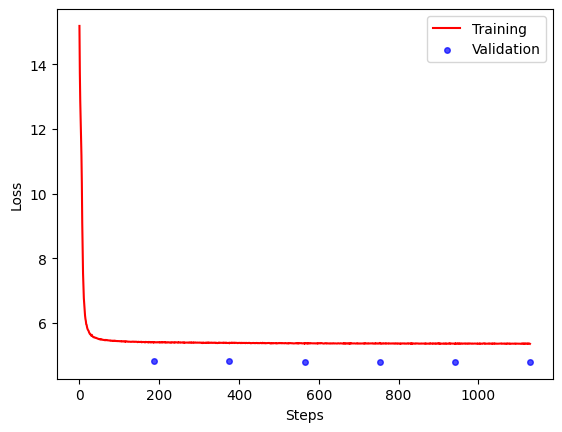

In [56]:
steps = df_trainer_logs.index
train_loss = df_trainer_logs.loss
eval_loss_list = df_trainer_logs.eval_loss

plt.plot(steps, train_loss, label="train_loss", color = "red")
plt.scatter(steps, eval_loss_list,
            c="blue", alpha=0.7, s=16)

plt.legend(["Training", "Validation"], loc ="upper right")
plt.xlabel("Steps")
plt.ylabel("Loss")

In [58]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [59]:
!pip install huggingface_hub

In [81]:
pip install git+https://github.com/huggingface/peft.git

  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-fi802bu2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-fi802bu2
  Resolved https://github.com/huggingface/peft.git to commit cf04d0353f0343cbf66627228c4495f51669af34
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.7.2.dev0-py3-none-any.whl size=169456 sha256=f43f1192c739f6eb8becab1b10533b15501a08dbc539daa22c15f7a45fb59b00
  Stored in directory: /tmp/pip-ephem-wheel-cache-26j2_n4h/wheels/d7/c7/de/1368fac8590e1b103ddc2ec2a28ad51d83aded1a3830e8a087
Successfully built peft
  Attempting uninstall: peft
    Found existing installation: peft 0.7.1
    Uninstalling peft-0.7.1:
      Successfully uninstalled peft-0.7.1


In [ ]:
peft_model = peft_model.merge_and_unload()

In [83]:
from huggingface_hub import notebook_login
notebook_login()

In [84]:
peft_model.push_to_hub("robuno/title-generation-bart-6000-v2-1")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/robuno/title-generation-bart-6000-v2-1/commit/ce28c96f82a6f1a3759cbc6eff726d6325f4996a', commit_message='Upload BartForConditionalGeneration', commit_description='', oid='ce28c96f82a6f1a3759cbc6eff726d6325f4996a', pr_url=None, pr_revision=None, pr_num=None)

In [85]:
tokenizer.push_to_hub("robuno/title-generation-bart-6000-v2-1")

CommitInfo(commit_url='https://huggingface.co/robuno/title-generation-bart-6000-v2-1/commit/1fe5be2fe4a3ccd2344a75519d6e346b30dfbbac', commit_message='Upload tokenizer', commit_description='', oid='1fe5be2fe4a3ccd2344a75519d6e346b30dfbbac', pr_url=None, pr_revision=None, pr_num=None)

# 5) Tracking Memory Usage

In [63]:
!nvidia-smi

Sun Dec 31 13:54:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              30W /  70W |  14163MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.5 GB
Cached:    13.7 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
